In [1]:
import scipy
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial import Delaunay

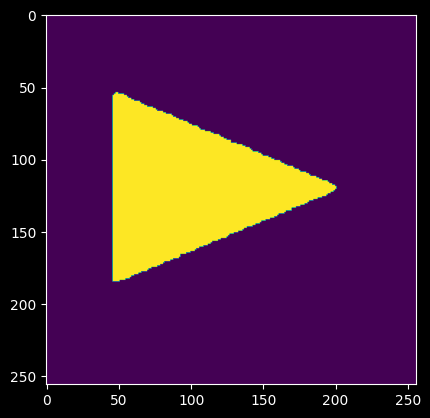

In [2]:

from utils import read_image, move_pixels_numpy, create_rect_mesh
from net import ConformalNet, check_inside_unit_disk, move_pixels_inverse_torch
from bc import diff_operator, bc_metric, get_area

from main import get_data

img, f_map = get_data()

plt.imshow(img[1,0])

In [3]:
face, vertex_0 = create_rect_mesh(256, 256)
Dx, Dy = diff_operator(face, vertex_0.reshape(-1, 2))

/home/extradisk/linchenran/.pyenv/versions/3.10.11/envs/hbs_seg/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
vertex = f_map[1,:,:,:].reshape(-1, 2).double()
e1 = vertex[face[:,2]] - vertex[face[:,1]]
e2 = vertex[face[:,0]] - vertex[face[:,2]]
e3 = vertex[face[:,1]] - vertex[face[:,0]]

xa, ya = e2[:, 0], e2[:, 1]
xb, yb = e1[:, 0], e1[:, 1]
area0 = (xb * ya - xa * yb) / 2

In [5]:
# vertex = f_map[0,:,:,:].reshape(-1, 2).double()
de1=Dx.mm(vertex)
de2=Dy.mm(vertex)

# area = (e1x.pow(2)+e1y.pow(2)).sqrt() * (e2x.pow(2)+e2y.pow(2)).sqrt() / 2
# area

In [35]:
def get_area(f_map, Dx, Dy):
    N, H, W, _ = f_map.shape
    f_map = f_map.reshape(N, -1, 2).transpose(0, 1).double()
    fx = f_map[:, :, 0]
    fy = f_map[:, :, 1]

    e1x = Dx.mm(fx).transpose(0, 1)
    e1y = Dx.mm(fy).transpose(0, 1)
    e2x = Dy.mm(fx).transpose(0, 1)
    e2y = Dy.mm(fy).transpose(0, 1)
    
    area = (e1x * e2y - e1y * e2x) / 2
    return area

area = get_area(f_map, Dx, Dy)

In [7]:
is_inside = img.reshape(5, -1)[:, face].all(2)

In [84]:
eps = 1e-9
torch.tanh(1e-5 / (area[is_inside]+eps)).norm()


tensor(90.7365, dtype=torch.float64)

In [15]:
n = 61255
face[n], vertex[face[n]], e1[n], e2[n],e3[n], area0[n], area[1,n]

(tensor([1434, 1433, 1178], dtype=torch.int32),
 tensor([[-0.9866,  0.1633],
         [-0.9866,  0.1633],
         [-0.9866,  0.1633]], dtype=torch.float64),
 tensor([0., 0.], dtype=torch.float64),
 tensor([0., 0.], dtype=torch.float64),
 tensor([0., 0.], dtype=torch.float64),
 tensor(0., dtype=torch.float64),
 tensor(0., dtype=torch.float64))

In [92]:
(img>0.5).reshape(5, 256, 256) == img.reshape(5, 256, 256)

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

In [ ]:
r = move_pixels_numpy(img[0], f_map[0] * 80+125)
plt.imshow(r[0])

In [ ]:
def check_inside_unit_disk(vertex: torch.Tensor, k=1e9):
    '''
    INPUT:
        vertex: N x H x W x 2 tensor
            original cordination of each pixel
    OUTPUT:
        result: N X H x W tensor
            whether the pixel is inside the unit circle
    '''
    # return torch.tanh((1 - torch.norm(vertex, 2, 3))*k) / 2 + 0.5
    return torch.sigmoid((1 - torch.norm(vertex, 2, 3))*k)

K = check_inside_unit_disk(f_map.reshape(1,H,W,2), 1e8).reshape(H,W)
plt.imshow(K, cmap='gray')
K.min(), K.max()

In [ ]:
unit_disk_points = (vertex * 4 - 2 * torch.DoubleTensor([W, H]).reshape(1,1,2)) / min(H,W)
unit_disk = check_inside_unit_disk(unit_disk_points.reshape(1,H,W,2)).reshape(H,W)
plt.imshow(unit_disk)

In [ ]:
img_circle = move_pixels_numpy(img[0,0].numpy(), f_map_rescale.numpy(), vertex.numpy())
plt.imshow(img_circle)

In [ ]:
# plt.imshow(img_m[0,0])
# img_circle_torch = torch.tensor(img_circle.reshape(1,1,*img.shape))
img_circle_torch = unit_disk.reshape(1,1,H,W)
f_map_torch = f_map_rescale.reshape(1, H, W, 2)

img_inverse = move_pixels_inverse_torch(img_circle_torch, f_map_torch).reshape(H,W)
plt.imshow(img_inverse)

In [ ]:
Dx, Dy = diff_operator(face, vertex.reshape(-1,2))
new_mu = bc_metric(f_map.reshape(1,H,W,2), Dx, Dy)
face_center = vertex.reshape(-1,2)[face[:,:], :].mean(1)
plt.figure(figsize=(15,15))
plt.imshow(img[0,0], cmap='gray')
plt.scatter(face_center[:,0], face_center[:, 1],s=0.1, c=new_mu[0].abs(), cmap='jet')

In [ ]:
net = ConformalNet(H, W)
output = net(img)
loss = net.loss(output.double(), img)
loss